In [8]:
## Tool to format csvs from bitmex_and_binance.py
## Changes timestamp to epoch time and adding technicals

import pandas as pd
import numpy as np
import time
import talib
import os
import logging
import matplotlib.pyplot as plt

In [9]:
unformatted_dir = "data/unformatted"
formatted_dir = "data/formatted"

logger = logging.getLogger("main")
logging.basicConfig(level=logging.INFO)

In [10]:
data = pd.read_csv(os.path.join(unformatted_dir, "BTCUSDT-1h-data.csv"), skiprows=[0], names=["timestamp","open","high","low","close","volume","close_time","quote_av","trades","tb_base_av","tb_quote_av","ignore"])
data.head()

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,150952.477943,7887.635513
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,92608.279728,8039.262402
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,20795.317224,8041.760498
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,1502956799999,19241.058300,25,2.602292,11291.347015,8048.127886
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.503586,28,0.814655,3552.746817,8018.036500


In [11]:
def ema(df, column="close", period=100):
    ema = df[column].ewm(period).mean()
    #emadata.plot()
    return ema

def rsi(df, column="close", period=30):
    # pylint: disable=no-member
    rsi = talib.RSI(df[column], timeperiod=period)
    return rsi

def bbands(df, column="close", period=20):
    # pylint: disable=no-member
    # https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/bollinger-bands
    upperBB, middleBB, lowerBB = talib.BBANDS(df[column], timeperiod=period, nbdevup=2, nbdevdn=2, matype=0)
    return [upperBB,middleBB,lowerBB]

In [12]:
unformatted_files = os.listdir(unformatted_dir)
formatted_files = os.listdir(formatted_dir)

for f in unformatted_files:
    logger.info(f"Formatting {f}")
    data = pd.read_csv(os.path.join(unformatted_dir, f), skiprows=[0], names=["timestamp","open","high","low","close","volume","close_time","quote_av","trades","tb_base_av","tb_quote_av","ignore"])

    for i in range(len(data["timestamp"])):
        t = data["timestamp"][i].split(".")[0]

        tstruct = time.strptime(t, "%Y-%m-%d %H:%M:%S")
        epoch_sec = int(time.mktime(tstruct))

        data["timestamp"][i] = epoch_sec

    data = data.drop(["trades", "quote_av", "tb_base_av", "tb_quote_av", "ignore", "close_time"], 1)

    data.set_index("timestamp", inplace=True)

    data["rsi"] = rsi(data, "close", period=30)
    data["ema"] = ema(data, "close", period=30)

    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    data.to_csv(os.path.join(formatted_dir, f))

INFO:main:Formatting BTCUSDT-1h-data.csv
c:\Users\jcwco\Documents\GitHub\zautocrypto\env\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\jcwco\Documents\GitHub\zautocrypto\env\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  app.launch_new_instance()
INFO:main:Formatting BTCUSDT-1m-data.csv


<AxesSubplot:xlabel='timestamp'>

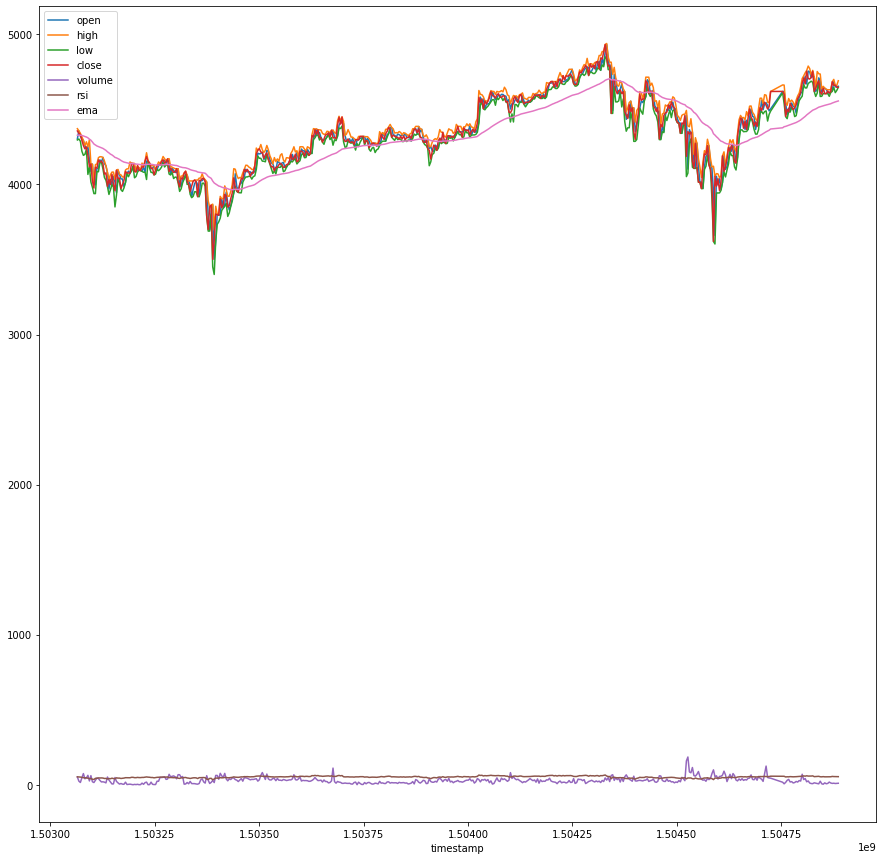

In [41]:
plt.rcParams["figure.figsize"] = (15,15)
data.head(500).plot()